In [3]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as numpy
import random

import sys
!{sys.executable} -m pip install neo4j-driver
from neo4j import GraphDatabase, basic_auth

!{sys.executable} -m pip install mysql-connector-python
import mysql.connector

import pymongo

# Connect to Databases

In [5]:
#Connect to MongoDB database
client = pymongo.MongoClient("mongodb://localhost:27017/")
eddb = client['EDDB']

#Connect to mySQL database
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="917177850",
    database="EDDB"
)
cursor = db.cursor()

#Connect to Neo4j database
driver = GraphDatabase.driver(
    "bolt://localhost:7687", 
    auth=basic_auth("neo4j", "915997582")
)
session = driver.session()

In [22]:
database_labels = ['MongoDB', 'Neo4j', 'mySQL']

def plot_timings(title, timings_data):
    plt.bar(database_labels, timings_data)
    plt.xlabel("Database")
    plt.ylabel("Time (sec)")
    plt.title(title)
    plt.show()

# Queries
1. How many systems does each faction control?
2. Find the commodity with the largest profit margin.
3. Find the system where you can buy a given commodity for the lowest price.
4. Find the system where you can sell a given commodity for the highest price.
5. Given a system and range, find the best commodity to buy and sell locally.
6. Find the nearest system that provides certain services.
7. Find the nearest system to sell at that contains the black market.
8. Find the rarest module and where to buy it.
9. Find the best path between two systems given the jump range of a ship.
10. Build aggregation of listings data to display the average cost of a given item, total supply, total demand.
11. (Neo4j only) Louvain graph algorithm to get the communities of systems for a given jump range of a ship.

## How many systems does each faction control?

### MongoDB

### Neo4j

### mySQL

## Find the commodity with the largest profit margin.
This query uses the aggregated data stored with the commodity to get a commodities profit margin

### MongoDB

In [41]:
def query_2_mongodb(timings = []):
    query = [
        {
            '$project': {
                'name': 1, 
                'id': 1, 
                'max_profit': {
                    '$subtract': [
                        '$max_sell_price', '$min_buy_price'
                    ]
                }, 
                'category': '$category.id', 
                'category_name': '$category.name', 
                'average_price': '$average_price'
            }
        }, {
            '$sort': {
                'max_profit': -1
            }
        }
    ]

    start = timer()
    results = eddb['commodities'].aggregate(query)
    end = timer()
    elapsed_time = end-start
    timings.append(elapsed_time)
    return results

In [42]:
results = query_2_mongodb()
print(list(results)[0])

{'_id': ObjectId('5fad8f308c30de7d2308e98e'), 'id': 362, 'name': 'Tritium', 'max_profit': 48450, 'category': 1, 'category_name': 'Chemicals', 'average_price': 42558}


### Neo4j

In [43]:
def query_2_neo4j(timings = []):
    query = """
            MATCH (c:Commodity)
            RETURN c.name, c.max_sell_price - c.min_buy_price as profit_margin
            ORDER BY profit_margin
            LIMIT 1
            """
    start = timer()
    result = session.run(query)
    end = timer()
    elapsed_time = end - start
    timings.append(elapsed_time)
    return result

In [44]:
results = query_2_neo4j()
print(list(results)[0])

<Record c.name='Explosives' profit_margin=None>


### mySQL

In [45]:
def query_2_mysql(timings = []):
    query = """
    SELECT name, max_sell_price, min_buy_price
    FROM commodity
    ORDER BY (max_sell_price - min_buy_price) DESC
    LIMIT 5
    """

    start = timer()
    cursor.execute(query)
    results = cursor.fetchall()
    end = timer()
    elapsed_time = end - start
    timings.append(elapsed_time)
    return results

In [46]:
results = query_2_mysql()
print(results[0])

('Tritium', 52455, 4005)


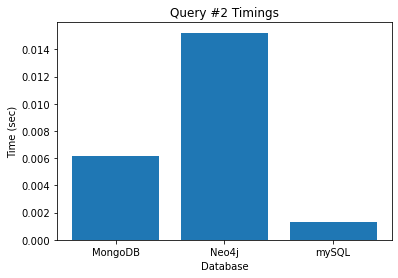

In [56]:
query_2_timings = []
#Run the queries to get the timings
query_2_mongodb(query_2_timings)
query_2_neo4j(query_2_timings)
query_2_mysql(query_2_timings)
#Plot the timings
plot_timings("Query #2 Timings", query_2_timings)

### Timings Explination
This query is a simple query that is only looking at one table for mySQL, one collection for MongoDB, and one node type for Neo4j. mySQL has the best performance of the three databases because it only needs to look at one table. No complex joins are necessary. MongoDB also performs well on queries that involve just one database too. That is why its performance is also significanly better than Neo4j. Neo4j performs the worst on these types of simple queries because of the way data is stored. Nodes of the same type are not stored together and accessing properties of nodes is also more expensive in Neo4j.

## Find the system where you can buy a given commodity for the lowest price.

### MongoDB

In [76]:
#Helper function to query for the commodity id based on the commodity name
def get_commodity_id(commodity_name):
    #query for the commodity id and filter to only include the id field
    filter={'name': commodity_name}
    project={'id': 1}
    result = eddb['commodities'].find(filter=filter, projection=project)
    #return the id from the result
    return result[0]['id']

#Helper function to query for the station name based on the commodity id
def get_station_name(station_id):
    #query for the station name and project only the station name
    filter={'id':station_id}
    project={'name': 1}
    result = eddb['stations'].find(filter=filter, projection=project)
    #return the name from the result
    return result[0]['name']

In [91]:
def query_3_mongodb(commodity_name, timings=[]):
    start = timer()
    commodity_id = get_commodity_id(commodity_name)
    #ensure the supply is greater than zero otherwise there is nothing to buy at the station and the buy_price will be zero
    query = [
        {
            '$match': {
                '$and': [
                    {
                        'commodity_id': commodity_id
                    }, {
                        'supply': {
                            '$gt': 0
                        }
                    }
                ]
            }
        }, {
            '$sort': {
                'buy_price': 1
            }
        }, {
            '$limit': 1
        }
    ]
    result = eddb['listings'].aggregate(query)
    data = list(result)
    #get the station id from the result
    station_id = data[0]['station_id']
    station_name = get_station_name(station_id)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return station_name

In [90]:
commodity_name = 'Liquid oxygen'
result = query_3_mongodb(commodity_name)
print(f'The station, {result}, has the lowest price to buy {commodity_name}')

2.415036100001089
The station, Bardeen Terminal, has the lowest price to buy Liquid oxygen


### Neo4j

In [87]:
def query_3_neo4j(commodity_name, timings=[]):
    query = f"""
        MATCH (c:Commodity {{name: '{commodity_name}'}})
        WITH c as commodity
        MATCH (commodity)-[r:BUY_AT]->(s:Station)
        RETURN s.name as station_name, r.buy_price as buy_price
        ORDER BY buy_price
        LIMIT 1
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return result

In [88]:
commodity_name = 'Liquid oxygen'
result = query_3_neo4j(commodity_name)
for row in result:
    print(f"{commodity_name} can be bought for the lowest price at {row['station_name']} for {row['buy_price']}.")

Liquid oxygen can be bought for the lowest price at Bardeen Terminal for 81.


mySQL

In [114]:
def query_3_mySQL(commodity_name, timings=[]):
    # get price
    query = """
    SELECT min_buy_price
    FROM commodity
    WHERE name = "{name}"
    """.format(name=commodity_name)

    start = timer()
    cursor.execute(query)

    results = cursor.fetchall()

    price = 0

    for x in results:
        price = x[0]

    # where is it
    query = """
    SELECT system_populated.name, station.name
    FROM listing
    JOIN station ON station.id=listing.station_id
    JOIN system_populated ON station.system_id=system_populated.id
    JOIN commodity ON listing.commodity_id=commodity.id
    WHERE commodity.name = "{name}" AND listing.buy_price = {price}
    """.format(name=commodity_name, price=price)

    cursor.execute(query)

    results = cursor.fetchall()
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return results


In [115]:
commodity_name = 'Liquid oxygen'
result = query_3_mySQL(commodity_name)
print(f"The station, {result[0]}, has the best price for {commodity_name}")

The station, ('Aegilips', 'Bardeen Terminal'), has the best price for Liquid oxygen


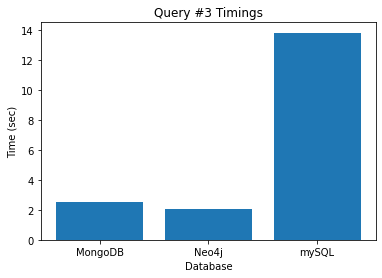

In [101]:
commodity_name = 'Liquid oxygen'
query_3_timings = []
#Run the queries to get thier timings
query_3_mongodb(commodity_name, query_3_timings)
query_3_neo4j(commodity_name, query_3_timings)
query_3_mySQL(commodity_name, query_3_timings)
#Plot the timings
plot_timings("Query #3 Timings", query_3_timings)

### Timings Explination
TODO :: fill with explication after changing mySQL to have correct results

## Find the station where you can sell a given commodity for the highest price.

### MongoDB

In [109]:
def query_4_mongodb(commodity_name, timings=[]):
    start = timer()
    commodity_id = get_commodity_id(commodity_name)
    #query for the station id where the commodity can bought for the lowest price
    #ensure the demand is greater than zero otherwise there is nothing to sell at the station and the sell_price will be zero
    query = [
        {
            '$match': {
                '$and': [
                    {
                        'commodity_id': commodity_id
                    }, {
                        'demand': {
                            '$gt': 0
                        }
                    }
                ]
            }
        }, {
            '$sort': {
                'sell_price': -1
            }
        }, {
            '$limit': 1
        }
    ]
    result = eddb['listings'].aggregate(query)
    data = list(result)
    #get the station id from the result
    station_id = data[0]['station_id']
    station_name = get_station_name(station_id)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return station_name

In [108]:
commodity_name = 'Beer'
result = query_4_mongodb(commodity_name)
print(f'The station, {result}, has the lowest price to buy {commodity_name}')

[{'_id': ObjectId('5fac46d58f47edbfef392f27'), 'id': 26948568, 'station_id': 45712, 'commodity_id': 8, 'supply': 0, 'supply_bracket': 0, 'buy_price': 0, 'sell_price': 4763, 'demand': 600194, 'demand_bracket': 3, 'collected_at': 1604344935}]
The station, Krylov Base, has the lowest price to buy Beer


### Neo4j

In [105]:
def query_4_neo4j(commodity_name, timings=[]):
    query = f"""
        MATCH (c:Commodity {{name: '{commodity_name}'}})
        WITH c as commodity
        MATCH (commodity)-[r:SELL_AT]->(s:Station)
        RETURN s.name as station_name, r.sell_price as sell_price
        ORDER BY sell_price DESC
        LIMIT 1
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)
    
    return result

In [106]:
commodity_name = 'Beer'
result = query_4_neo4j(commodity_name)
for row in result:
    print(f"{commodity_name} can be sold for the highest price at {row['station_name']} for {row['sell_price']}.")

Beer can be sold for the highest price at Stabenow Reformatory for 4763.


### mySQL

In [120]:
def query_4_mysql(commodity_name, timings=[]):
    # get price
    query = """
    SELECT max_sell_price
    FROM commodity
    WHERE name = "{name}"
    """.format(name=commodity_name)

    start = timer()
    cursor.execute(query)

    results = cursor.fetchall()

    price = 0

    for x in results:
        price = x[0]

    # where is it
    query = """
    SELECT system_populated.name, station.name
    FROM listing
    JOIN station ON station.id=listing.station_id
    JOIN system_populated ON station.system_id=system_populated.id
    JOIN commodity ON listing.commodity_id=commodity.id
    WHERE commodity.name = "{name}" AND listing.sell_price = {price}
    """.format(name=commodity_name, price=price)

    cursor.execute(query)

    results = cursor.fetchall()
    end = timer()

    elapsed_timer = end - start
    timings.append(elapsed_timer)

    return results

In [121]:
commodity_name = 'Beer'
result = query_4_mysql(commodity_name)
print(f'{result} is where {commodity_name} can be sold for the highest price.')

[('Lyncis Sector DB-X c1-9', 'VanderMeer Legacy'), ('Peregrina', 'Stabenow Reformatory'), ('HIP 101613', 'Lorrah Reach'), ('HERZ 10688', 'Krylov Base')] is where Beer can be sold for the highest price.


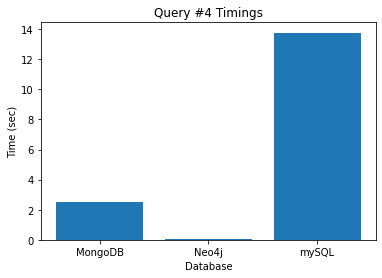

In [123]:
commodity_name = 'Beer'
query_4_timings = []
#Run the queries to get their timings
query_4_mongodb(commodity_name, query_4_timings)
query_4_neo4j(commodity_name, query_4_timings)
query_4_mysql(commodity_name, query_4_timings)
#Plot the timings
plot_timings("Query #4 Timings", query_4_timings)

### Timings Explination
**The explination for this query is the same as for query #3 since they are doing similar operations.**

Neo4j runs in the best amount of time because this type of query is taking advantage of Neo4j's relationships. Neo4j will figure out the commodity it is looking for and reduce its search space to only the relationships coming out of that commodity making for a much more efficient query. TODO :: Finish once systems are also on Mongo and Neo queries